## M/M/C/C

The M/M/C/C model is a simulation that contains C servers with a capacity of C. This means any attempt for a new customer to join when the system is full will result in them being rejected from the system.

### Excercise 1.1

The code below imports the required functions from external libraries and runs the expon function which is used with both Models.

In [1]:
from math import log, factorial
from random import uniform
from sys import float_info
from numpy import arange

import matplotlib.pyplot as plt

def expon(mean):
    '''
    Generates a random variate.
    
    Args:
        mean: mean of the random variate.
        
    Returns: float which is an exponential random variate with mean "mean".
    '''
    
    return -mean * log(uniform(0, 1))

In [2]:
def drawGraphs(bp=None, su=None, cps=None, bpExact=None, suExact=None, cpsExact=None, loc='best'):
    '''
    This function draws two graphs both sharing a domain of call arrival
    rates which are plotted against the blocking probability and server
    utilisation results for that arrival rate.
    
    Args:
        bp: blocking probability results.
        su: server utilisation results.
        cps: calls per second values.
        exact: use 'True' if you want to plot exact results.
        bpExact: exact blocking probability results.
        suExact: exact server utilisation results.
        cpsExact: exact calls per second values.
    '''
    
    # Blocking Probability
    if bp:
        plt.plot(cps, bp, 'k.', label='Simulation')
        plt.plot(cpsExact, bpExact, 'r', label = 'Analytical')
    
        plt.legend(loc=loc)
        plt.ylabel('Blocking Probability')
        plt.xlabel('Call / second')
        plt.show()
    
    # Server Utilisation
    if su:
        plt.plot(cps, su, 'k.', label = 'Simulation')
        plt.plot(cpsExact, suExact, 'r', label = 'Analytical')
        
        plt.legend(loc=loc)
        plt.ylabel('Server Utilisation')
        plt.xlabel('Call / second')
        plt.show()

The following code is the Model. I have designed it to be reusable, easy to understand with lots of comments and doc-strings so that it can be used in the future for other applications. There have been no hard coded numbers and was written so that it is independant of the tasks set to me. I choose to encapsulate the model within a class, the reason for this was the large number of variables that need to be tracked it would be cumbersome to pass them through each function every time. Within the model I seperated the parts into distinct sections such as timing and arrival events to keep the class simple to comprehend. To get results from the model there is a report method which can either print results or returns it to be analysed with further code.

In [3]:
class Model():
    def __init__(self, la, mu, c, N):
        '''
        Method to initialise the M/M/C/C model.
        
        Args:
            la - the  interarrival rate.
            mu - the service time.
            c - the number of servers.
            N - the number of customers run through simulation.
        '''

        # Options
        self.la = la
        self.mu = mu
        self.c = c
        self.N = N

        # State Variables
        self.numCustomer = 0 # Number of customers that have arrived.
        self.serverStatus = [0] * c # Tracks state of server, idle (0) or busy (1).
        self.nextEventType = 0 # Next event type to occur.
        self.timeNextEvent = [expon(la)] + [float_info.max for _ in range(c)] # Time till each event occurs.
        
        # Report Variables
        self.simTime = 0.0 # Simulation time, used to calculate effeciency statistics.
        self.areaServerStatus = [0] * c # Time each server is being used.
        self.timeLastEvent = 0.0 # The previous time an event happened, used to calculate effeciency statistics.
        self.customerLost = 0 # Customers that are rejected from the system.


    def timing(self):
        '''
        Method iterates through timeNextEvent list and finds the smallest time,
        thus the event that will be occuring next.
        '''
        
        # Find index of smallest value from timeNextEvent.
        minValue = min(self.timeNextEvent)
        index = self.timeNextEvent.index(minValue)
        
        # Set nextEventType.
        self.nextEventType = index
        
        # Update timing statistics.
        self.timeLastEvent = self.simTime
        self.simTime = minValue


    def arrive(self):
        '''
        Method to represent an arrival event. Checks to see if system has space,
        then allocates to the specific server else is rejected from the system.
        '''

        # Set time of new arrival event.
        self.timeNextEvent[0] = self.simTime + expon(self.la)

        # New customer registered.
        self.numCustomer += 1
        
        # Find number of free servers.
        freeServers = self.serverStatus.count(0)
        
        # Check there is at least one free server.
        if freeServers > 0:
            
            # Find index of an idle server.
            idleServer = self.serverStatus.index(0)
            
            # Set server to busy.
            self.serverStatus[idleServer] = 1
            
            # Set departure time for the server.
            self.timeNextEvent[idleServer+1] = self.simTime + expon(self.mu)
         
        else:
            
            # Customer rejected from system.
            self.customerLost += 1


    def depart(self):
        '''
        Method to represent a departure event. Sets server to idle and changes time
        for next event.
        '''
        
        # Retrieves server index that has completed.
        index = self.nextEventType

        # Sets server to idle.
        self.serverStatus[index-1] = 0
        
        # Set time to max to ensure it is not used.
        self.timeNextEvent[index] = float_info.max


    def updateStats(self):
        '''
        Method to update the total time being used for each of the servers.
        '''
        
        # Time since last event added 
        timePast = self.simTime - self.timeLastEvent

        # For every server, add timePast if server was busy.
        for i in range(self.c):
            self.areaServerStatus[i] += timePast * self.serverStatus[i]
         
        
    def report(self, printOut=False):
        '''
        Works out the blocking probability and server utilisation of the
        simulation.
        
        Args:
            printOut: set to True if print out of results is desired.
            
        Returns: The blocking probability and the server utilisation in a tuple.
        '''
        
        # Work out calculations.
        blockingProbability = self.customerLost / self.N
        serverUtilisation = sum(self.areaServerStatus) / self.simTime / self.c
        
        if printOut:

            # Print out calculations.
            print('Blocking Probability:', blockingProbability)
            print('Server Utilisation:', serverUtilisation)
            
        return blockingProbability, serverUtilisation
        
        
    def run(self):
        '''
        Initialises the running of the simulation.
        Ends when certain number of customers has entered the system.
        '''
        
        # Continue until N customers arrive into the system.
        while(self.numCustomer < self.N):
            
            # Work out next event
            self.timing()
            
            # Update statistics for the simulation.
            self.updateStats()
            
            # Process next event depending on next event type.
            if self.nextEventType == 0:
                self.arrive()
            else:
                self.depart()

The code below contains functions that I created that are more specific to the tasks I have been set for the coursework, there are several possibilities that can be achieved using the code. The first is to find average results for both blocking probability and server utilisation after running the simulation a set number of times, this can be used on its own to find results for certain sets of parameters. These results can then be used to produce graphs which is expected in excercise 1.2.

Additionally this function is used within another called get simulation results which can procude lists of results which can then be further analysed. To validate this there is another function called getExactResults which analytically calculates the blocking probabilty and sever utilisation. Finally the function maximumValue was created to satisfy excercise 1.3, it starts at a value and incrementally gets smaller until the blocking probability is below a certain limit. This has a parameter for precision so it can be as accurate as the user wants.

In [4]:
def averageResult(la, mu, c, N, repeat):
    '''
    Runs the simulation multiple times and generates the average.
    
    Args:
        la: the interarrival rate.
        mu: the service time.
        c: the number of servers.
        N: number of customers required before ending simulation.
        repeat: the number of times the simulation should be run.
        
    Returns: the average results of blocking probability and server
             utilisation obtained from the simulator after repeat trials.
    '''
    
    # Initialise variables to store results.
    bp = 0
    su = 0
    
    # Run simulator 'repeat' times.
    for _ in range(repeat):
        
        # Generate, run and find results of model.
        model = Model(la, mu, c, N)
        model.run()
        result = model.report()
        
        # Add the results to the previous variables
        bp += result[0]
        su += result[1]
    
    # Divide total results by 'repeat' to find average.
    bp /= repeat
    su /= repeat
    
    return bp, su
    
    
def getSimulationResults(start=0.01, stop=1, interval=0.05, mu=100, c=16, N=100000, repeat=3):
    '''
    A function that gets the results of a simulation. The function
    takes the average of the results from the simulation being run
    multiple times given certain parameters. It does this for each
    interval of calls per second.
    
    Args:
        start: the starting value for call rate.
        stop: the ending value for call rate.
        interval: the step size of increasing call rate.
        mu: the service time.
        c: the number of servers.
        N: number of customers required before ending simulation.
        repeat: the number of times the simulation should be run.
        
    Returns: three lists containing results for blocking probability,
             server utilisation and the corresponding calls per second.
    '''
    
    # Generates list of calls per second.
    callsPerSecond = arange(start, stop, interval)
    
    bp = [] # Blocking probability results.
    su = [] # Server utilisation results.
    
    # Gets results for each arrival rate
    for call in callsPerSecond:

        # Generates average result of simulation using (1 / calls per second) as arrival rate.
        result = averageResult(1/call, mu, c, N, repeat)
        
        # Add results to respective lists.
        bp.append(result[0])
        su.append(result[1])
        
    return bp, su, callsPerSecond


def exactResults(la, mu, c):
    '''
    Analytically calculates the blocking probability and
    server utilisation for a system with certain parameters.
    
    Args:
        la: the interarrival rate.
        mu: the service time.
        c: the number of servers.
    '''

    # Calculate blocking probability.
    x = (la / mu) ** c / factorial(c)
    y = 0
    for k in range(c + 1):
        y += (la / mu) ** k / factorial(k)
    bp = x / y
    
    # Calculate server utilisation.
    z = la / mu
    nb = (1 - bp) * z
    su = nb / c

    return bp, su


def getExactResults(start=0.01, stop=1, interval=0.001, mu=1/100, c=16):
    '''
    A function that analytically generates results of blocking
    probability and server utilisation given a certain set of
    input parameters.
    
    Args:
        start: the starting value for call rate.
        stop: the ending value for call rate.
        interval: the step size of increasing call rate.
        mu: the service time.
        c: the number of servers.
        
    Returns: three lists containing results for blocking probability,
             server utilisation and the corresponding calls per second.
    '''
    
    # Generates list of calls per second.
    callsPerSecond = arange(start, stop, interval)
    
    bp = [] # Blocking probability results.
    su = [] # Server utilisation results.
    
    # Gets results for each arrival rate
    for call in callsPerSecond:
        
        res = exactResults(call, mu, c)
        
        # Add results to respective lists.
        bp.append(res[0])
        su.append(res[1])
        
    return bp, su, callsPerSecond


def maximumValue(start=0.1, precision=0.01, limit=0.01, mu=100, c=16, N=100000, repeat=3):
    '''
    A function that predicts the call rate needed for the
    blocking probability to be below a certain value.
    
    Args:
        start: the value the system begins with.
        precision: the increments that trials will take place.
        limit: the maximum allowed value of blocking probability.
        mu: the service time.
        c: the number of servers.
        N: number of customers required before ending simulation.
        repeat: the number of times the simulation should be run.
        
    Returns: the callRate that produes blocking probability below
             'limit' and with precision 'precision'.
    '''
    
    callRate = start
    
    while True:
        
        # Round to remove floating point errors.
        callRate = round(callRate - precision, 6)
        
        # Get avergae blocking probability for call rate.
        bp = averageResult(1/callRate, mu, c, N, repeat)[0]
        
        # Check if blocking probability is less than allowed limit.
        if bp < limit:
            
            # Output results
            print('Calls per second:', callRate)
            print('Blocking Probability', round(bp, 6))
            
            # Stop looping
            return callRate

The following code generates graphs over a large domain of call rates, simulation results are displayed as dots on the graph whilst the analytical version is displayed as a red line. I have used a large domain range to get an overview of the space and therefore can be confident in verifying the validity of the simulation.

In [5]:
bp, su, cps = getSimulationResults()
bpExact, suExact, cpsExact = getExactResults()

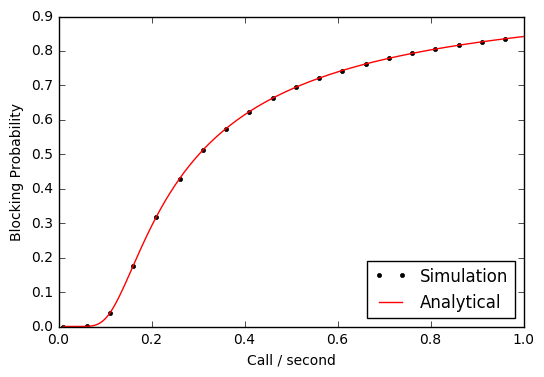

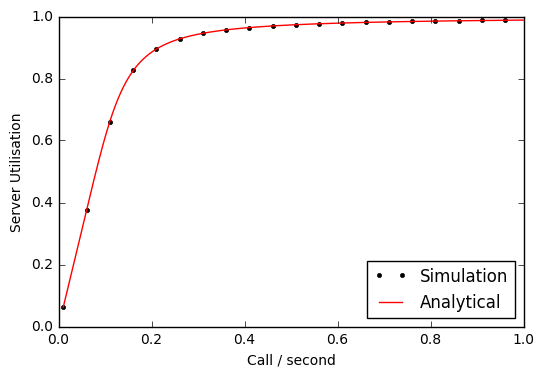

In [6]:
drawGraphs(bp, su, cps, bpExact, suExact, cpsExact, 'lower right')

The graphs show that the simulation is accurate and closely represents the analytical solution.

### Excercise 1.2

For task 1.2 I was requested to:

    'Draw figures to depict the performance results for the Blocking Probability and the Server Utilization by changing the value of arrival rate (0.01 - 0.1 call/second).'
    
The following code gathers the results needed and then displays them on a graph.

In [7]:
bp, su, cps = getSimulationResults(start = 0.01,
                                   stop = 0.1,
                                   interval=0.005)

bpExact, suExact, cpsExact = getExactResults(start = 0.01,
                                               stop = 0.1,
                                               interval=0.0001)

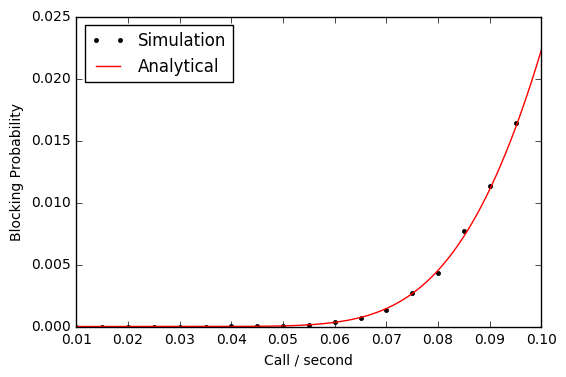

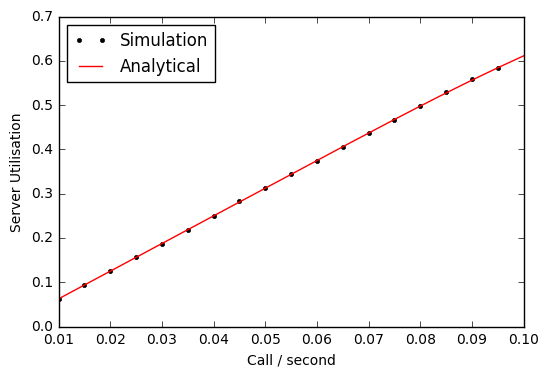

In [8]:
drawGraphs(bp, su, cps, bpExact, suExact, cpsExact, loc='upper left')

### Excercise 1.3

For task 1.3 I was requested to:
    
    'Find the maximum value for input rates so that the Blocking Probability < 0.01.'
    
The following code works out the value that the arrival rate can be so that the blocking probabiliity is less than 0.01. An argument precision is given which is how accurate the value for the arrival rate will be. The calls per second value is given along with the blocking probability that resulted from it. The graphs above can be used to gain an approximate result which can be used as the start argument to save time.

In [9]:
maxCallRate = maximumValue(start=0.089, precision=0.0001)

Calls per second: 0.0889
Blocking Probability 0.00996


# M1+M2/M/C/C

The M1+M2/M/C/C model is a simulation that contains C servers with a capacity of C. This means any attempt for a new customer to join when the system is full will result in them being rejected from the system. Additionally there are two differents types of input into the system the first is when a normal user arrives and the other is when a user with priority arrives into the system, for this to be possible the model allows the setting of a value n1 which is the threshold, meaning if there are only two free servers only handover calls can enter the system unlike new calls which will be rejected from the system.

### Excercise 2.1

The code below represents a M1+M2/M/C/C model. The model itself is similar to the M/M/C/C model that has been implemented above however the key difference with this is that there are two arrival rates, one for regular customers and another for priority customers, in addition to this a threshold paramater must be given to the model to signify how many servers should be reserved. The format of the model has remained mostly unchanged except for changing of the arrival event to accomodate two different arrival types.

In [10]:
class Model():
    def __init__(self, la, la2, mu, c, N, n1):
        '''
        Method to initialise the M1+M2/M/C/C model.
        
        Args:
            la - the new call arrival rate.
            la2 - the handover call arrival rate.
            mu - the service time.
            c - the number of servers.
            N - the number of customers run through simulation.
            n1 - the number of reserved servers for handover.
        '''

        # Options
        self.la = la
        self.la2 = la2
        self.mu = mu
        self.c = c
        self.N = N
        self.n1 = n1

        # State Variables
        self.serverStatus = [0] * c # Tracks state of server, idle (0) or busy (1).
        self.nextEventType = 0 # Next event type to occur.
        self.timeNextEvent = [expon(la), expon(la2)] + [float_info.max for _ in range(c)] # Time till each event occurs.

        # Report Variables
        self.simTime = 0.0 # Simulation time, used to calculate effeciency statistics.
        self.areaServerStatus = [0] * c # Time each server is being used.
        self.timeLastEvent = 0.0 # The previous time an event happened, used to calculate effeciency statistics.
        self.newCall = 0 # New calls arriving at system.
        self.newCallLost = 0 # New calls rejected from system.
        self.handoverCall = 0 # Handover calls arriving at system.
        self.handoverCallLost = 0 # Handover calls rejected from system.


    def timing(self):
        '''
        Method iterates through timeNextEvent list and finds the smallest time,
        thus the event that will be occuring next.
        '''

        # Find index of smallest value from timeNextEvent.
        minValue = min(self.timeNextEvent)
        index = self.timeNextEvent.index(minValue)
        
        # Set nextEventType.
        self.nextEventType = index
        
        # Update timing statistics.
        self.timeLastEvent = self.simTime
        self.simTime = minValue


    def arrive(self, event):
        '''
        Method to represent an arrival event. Checks to see if system has space,
        then allocates to the specific server else is rejected from the system.
        '''
        
        # Works out number of free servers.
        freeServers = self.serverStatus.count(0)

        # New call arriving.
        if event == 0:
            
            # Set time of next arrival.
            self.timeNextEvent[0] = self.simTime + expon(self.la)
            
            # Register arrival in the system.
            self.newCall += 1
            
            # If free servers is greater than the threshold.
            if freeServers > self.n1:
                
                # Accept new call.
                idleServer = self.serverStatus.index(0)
                self.serverStatus[idleServer] = 1
                self.timeNextEvent[idleServer+2] = self.simTime + expon(self.mu)
                
            else:
                
                # Customer rejetced.
                self.newCallLost += 1
           
        # Handover call arriving.
        if event == 1:
            
            # Set time of next arrival.
            self.timeNextEvent[1] = self.simTime + expon(self.la2)
            
            # Register arrival in the system.
            self.handoverCall += 1
            
            # If there exists free servers.
            if freeServers > 0:
                
                # Accept new call.
                idleServer = self.serverStatus.index(0)
                self.serverStatus[idleServer] = 1
                self.timeNextEvent[idleServer+2] = self.simTime + expon(self.mu)
                
            else:
                
                # Customer rejetced.
                self.handoverCallLost += 1
            


    def depart(self):
        '''
        Method to represent a departure event. Sets server to idle and changes time
        for next event.
        '''
        
        # Finds server that has completed
        index = self.nextEventType
        
         # Sets server to idle.
        self.serverStatus[index-2] = 0
        
        # Set time to max to ensure it is not used.
        self.timeNextEvent[index] = float_info.max


    def updateStats(self):
        '''
        Method to update the total time being used for each of the servers.
        '''
        
        # Time since last event added 
        self.timePast = self.simTime - self.timeLastEvent

        # For every server, add timePast if server was busy.
        for i in range(self.c):
            self.areaServerStatus[i] += self.timePast * self.serverStatus[i]
        
         
        
    def report(self, printOut=False):
        '''
        Works out the aggregate blocking probability and server utilisation of the
        simulation.
        
        Args:
            printOut: set to True if print out of results is desired.
            
        Returns: The aggregate blocking probability and the server utilisation in a tuple.
        '''
        
        # Work out calculations.
        cbp = self.newCallLost / self.newCall
        hfp = self.handoverCallLost / self.handoverCall
        agg = cbp + 10 * hfp
        
        serverUtilisation = sum(self.areaServerStatus) / self.simTime / self.c
        
        if printOut:
            
            # Print out calculations.
            print('New Calls', self.newCall)
            print('New Calls Lost', self.newCallLost)
            print()
            print('Handover Calls', self.handoverCall)
            print('Handover Calls Lost', self.handoverCallLost)
            print()
            print('CBP:', cbp)
            print('HFP:', hfp)
            print()
            print('Agg Blocking Probability:', agg)
            print('Server Utilisation:', serverUtilisation)
            
        return agg, serverUtilisation

        
    def run(self):
        '''
        Initialises the running of the simulation.
        Ends when certain number of customers has entered the system.
        '''
        
        # Continue until N customers arrive into the system.
        while((self.newCall + self.handoverCall) < self.N):
            
            # Work out next event
            self.timing()
            
            # Update statistics for the simulation.
            self.updateStats()
            
            # Process next event depending on next event type.
            if self.nextEventType == 0:
                
                # Process new call event.
                self.arrive(0)
                
            elif self.nextEventType == 1:
                
                # Process handover call event.
                self.arrive(1)
                
            else:
                
                # Process depart event.
                self.depart()

The code below has been written specificly for the coursework tasks however I have again kept the functions flexible meaning they could be used for other tasks if needed. One significant difference is the introduction of the 'first' parameter which determines which arrival rate will be changing through the experiments. If it is True then the regular new calls will be fixed however, when false the handover call rate will be fixed and the regular calls will change.

In [11]:
def averageResult(la, la2, mu, c, N, n1, repeat):
    '''
    Runs the simulation multiple times and generates the average.
    
    Args:
        la: the new call arrival rate used in the simulation.
        la2: the handover call arrival rate used in the simulaion.
        mu: the service time.
        c: the number of servers.
        N: number of customers before ending the simulation.
        n1: the threshold of priority servers.
        repeat: the number of times the simulation should be run.
        
    Returns: the average results of blocking probability and server
             utilisation obtained from the simulator.
    '''
    
    # Initialise variables to store results.
    bp = 0
    su = 0
    
    # Run simulator N times.
    for _ in range(repeat):
        
        # Generate, run and find results of model.
        model = Model(la, la2, mu, c, N, n1)
        model.run()
        result = model.report()
        
        # Add the results to the previous variables
        bp += result[0]
        su += result[1]
    
    # Divide total results by N to find average.
    bp /= repeat
    su /= repeat
    
    return bp, su
    
    
def getSimulationResults(start=0.01, stop=1, interval=0.05, la=1/0.01, mu=100, c=16, N=100000, n1=2, repeat=3, first=True):
    '''
    A function that gets the results of a simulation. The function
    takes the average of the results from the simulation being run
    multiple times given certain parameters. It does this for each
    interval of calls per second.
    
    Args:
        start: the starting value for call rate.
        stop: the ending value for call rate.
        interval: the step size of increasing call rate.
        la: the fixed arrival rate.
        mu: the service time.
        c: the number of servers.
        N: number of customers required before ending simulation.
        n1: the threshold of priority servers.
        repeat: the number of times the simulation should be run.
        first: if True la2 is fixed and la is changed else vice versa.
        
    Returns: three lists containing results for blocking probability,
             server utilisation and the corresponding calls per second.
    '''
    
    # Generates list of calls per second.
    callsPerSecond = arange(start, stop, interval)
    
    bp = [] # Blocking probability results.
    su = [] # Server utilisation results.
    
    # Gets results for each arrival rate
    for call in callsPerSecond:
        
        # Change the variable of the new call rate.
        if first:
            
            # Generates average result of simulation using (1 / calls per second) as arrival rate.
            result = averageResult(1/call, la, mu, c, N, n1, repeat)
        
        # Change the variable of the handover call rate.
        else:
            
            # Generates average result of simulation using (1 / calls per second) as handover rate.
            result = averageResult(la, 1/call, mu, c, N, n1, repeat)
        
        # Add results to respective lists.
        bp.append(result[0])
        su.append(result[1])
        
    return bp, su, callsPerSecond


def p0(la1, la2, mu, c, N):
    '''
    Works out intitial state probability.
    
    Args:
        la1: new call arrival rate.
        la2: handover arrival rate.
        mu: service time.
        c: number of servers.
        N: priority server number.
        
    Returns: initial state probability.
    '''
    
    x = 0
    
    for k in range((c-N)+1):
        
        y1 = 1 / factorial(k)
        
        y2 = ((la1 + la2) / mu) ** k
        
        x += y1 * y2
        
    for k in range(c - N + 1, c + 1):
        
        y1 = 1 / factorial(k)
        
        y2 = ((la1 + la2) / mu) ** (c - N)
        
        y3 = (la1 / mu) ** (k - (c - N))
        
        x += y1 * y2 * y3

    return 1 / x
        
    
def pk(la1, la2, mu, c, N, k):
    '''
    Works out state probabilities for state k.
    
    Args:
        la1: new call arrival rate.
        la2: handover arrival rate.
        mu: service time.
        c: number of servers.
        N: priority server number.
        k: the state to work out.
        
    Returns: state probability of state k.
    '''
    
    y0 = p0(la1, la2, mu, c, N)
        
    if 0 <= k and k <= c - N:

        y1 = 1 / factorial(k)

        y2 = ((la1 + la2) / mu) ** k

        return y1 * y2 * y0

    elif (c - N) + 1 <= k and k <= c:
        
        y1 = 1 / factorial(k)

        y2 = ((la1 + la2) / mu) ** (c - N)

        y3 = (la1 / mu) ** (k - (c - N))

        return y1 * y2 * y3 * y0
        
        
def newLoss(la1, la2, mu, c, N):
    '''
    Works out the loss probability for new calls.
    
    Args:
        la1: new call arrival rate.
        la2: handover arrival rate.
        mu: service time.
        c: number of servers.
        N: priority server number.
        
    Returns: loss probability of new calls.
    '''
    
    x = 0
    
    for k in range(c - N, c + 1):
        
        x += pk(la1, la2, mu, c, N, k)
        
    return x


def blockingProb(la1, la2, mu, c, N):
    '''
    Function to calculate aggregate blocking probability of
    a model given certain inputs.
    
    Args:
        la1: new call arrival rate.
        la2: handover arrival rate.
        mu: service time.
        c: number of servers.
        N: priority server number.
        
    Returns: aggregate blocking probability.
    '''
    # Reverse la1 and la2 because they are opposite in my simulation.
    new = newLoss(la2, la1, mu, c, N)
    handover = pk(la2, la1, mu, c, N, c)
    
    return new + 10 * handover


def getExactResults(start=0.01, stop=1, interval=0.001, la=0.01, mu=1/100, c=16, n1=2, first=True):
    '''
    A function that analytically generates results of blocking
    probability and server utilisation given a certain set of
    input parameters.
    
    Args:
        start: the starting value for call rate.
        stop: the ending value for call rate.
        interval: the step size of increasing call rate.
        mu: the service time.
        c: the number of servers.
        
    Returns: three lists containing results for blocking probability,
             server utilisation and the corresponding calls per second.
    '''
    
    # Generates list of calls per second.
    callsPerSecond = arange(start, stop, interval)
    
    bp = [] # Blocking probability results.
    su = [] # Server utilisation results.
    
    # Gets results for each arrival rate
    for call in callsPerSecond:
        
        # Change variable of the new call rate.
        if first:
            
            # Add results to respective lists.
            bp.append(blockingProb(call, la, mu, c, n1))
            
        else:
            
            bp.append(blockingProb(la, call, mu, c, n1))
        
    return bp, su, callsPerSecond


def maximumValue(start=0.01, precision=0.001, limit=0.02, mu=100, c=16, N=100000, n1=2, repeat=1, fixed=0.03, first=True):
    '''
    A function that predicts the call rate needed for the
    blocking probability to be below a certain value.
    
    Args:
        start: the value the system begins with.
        precision: the increments that trials will take place.
        limit: the maximum allowed value of blocking probability.
        mu: the service time.
        c: the number of servers.
        N: number of customers required before ending simulation.
        repeat: the number of times the simulation should be run.
        first: if True la2 is fixed and la is changed else vice versa.
        
    Returns: the callRate that produes blocking probability below
             'limit' and with precision 'precision'.
    '''
    
    callRate = start
    
    while True:
        
        
        # Round to remove floating point errors.
        callRate = round(callRate - precision, 5)
        
        # Change the variable of the new call rate.
        if first:
        
            # Get avergae blocking probability for call rate.
            bp = averageResult(1/callRate, fixed, mu, c, N, n1, repeat)[0]
        
        # Change the variable of the handover call rate.
        else:
            
            # Get avergae blocking probability for call rate.
            bp = averageResult(fixed, 1/callRate, mu, c, N, n1, repeat)[0]
        
        # Check if blocking probability is less than allowed limit.
        if bp < limit:
            
            # Output results
            print('Calls per second:', callRate)
            print('Blocking Probability', round(bp, 5))
            
            # Stop looping
            return callRate

The code below is to validate the simulation.

In [12]:
bp, su, cps = getSimulationResults()
bpExact, suExact, cpsExact = getExactResults()

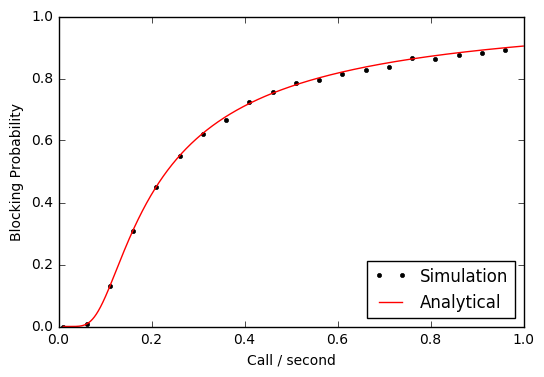

In [13]:
drawGraphs(bp=bp, cps=cps, bpExact=bpExact, cpsExact=cpsExact, loc='lower right')

The results of the simulation are the black dots whilst the exact values are represented by the red line. The majority of dots are on the red line and therefore the simulation is proving to be quite accurate, this accuracy could be improved by increasing the number of customers going into the system. I did this over the domain from 0.01 to 1.0 to ensure there is a big enough range to see if diverted at any point, however it did not meaning I can be fairly confident this is correct.

### Excercise 2.2

For task 2.2 I was requested to:

    'Set the new call arrival rate = 0.1 call/second. Find the maximum value for the handover rate so that the Aggregated Blocking Probability (ABP) < 0.02.'
    
I attempted to generate a graph showing that the desired values are not possible with a new call arrival rate of 0.1.

In [14]:
start = 0.001
stop = 0.1
la = 0.1
first = False

bp, su, cps = getSimulationResults(start = start,
                                   stop = stop,
                                   interval=0.01,
                                   la= 1 / la,
                                   first = first)

bpExact, suExact, cpsExact = getExactResults(start = start,
                                             stop = stop,
                                             interval = 0.001,
                                             la = la,
                                             first = first)

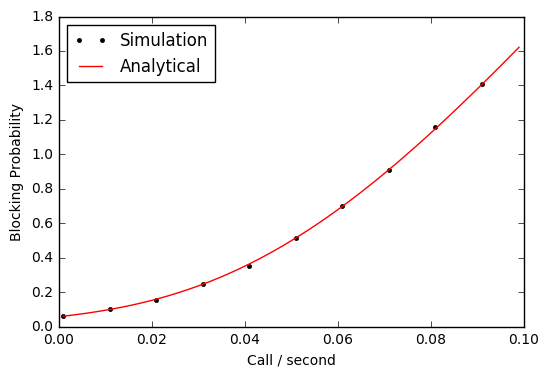

In [15]:
drawGraphs(bp=bp, cps=cps, bpExact=bpExact, cpsExact=cpsExact)

In this example the new call rate is set to 0.1, when there is no handover calls this model is identical to the M/M/C/C simulator. If we look at that graph from part 1 with domain 0.01 to 0.1 we can see the value is approximately 0.22. This is already above the threshold given for this task. In addition because there are essentially two less servers this value will be even higher for this model. It is because of the previous reasons that it will be impossible to set the handover calls low enough that the aggregated blocking probability will be below 0.02 and so this question is impossible to answer.

### Excercise 2.3

For task 2.3 I was requested to:

    'Set the handover rate = 0.03 handover/second. Find the maximum value for the new call rates so that the ABP < 0.02.'
    
I began my collectring corrseponding results and displaying them on graph this will give me good idea of the general location of the maximum value for new call rates that lead to ABP < 0.02. 

In [16]:
start = 0.01
stop = 0.1
la = 0.03
first = True

bp, su, cps = getSimulationResults(start = start,
                                   stop = stop,
                                   interval=0.01,
                                   la= 1 / la,
                                   first = first)

bpExact, suExact, cpsExact = getExactResults(start = start,
                                             stop = stop,
                                             interval = 0.001,
                                             la = la,
                                             first = first)

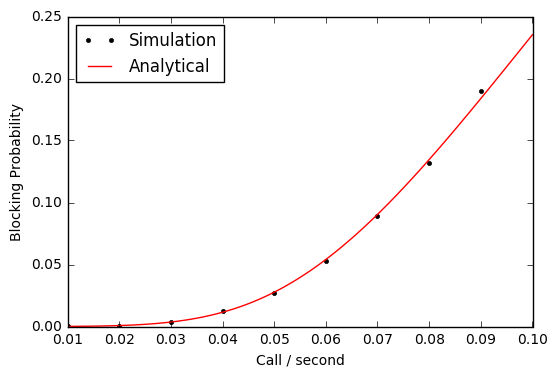

In [17]:
drawGraphs(bp=bp, cps=cps, bpExact=bpExact, cpsExact=cpsExact)

The blocking probability graph shows that maximum value is at most 0.05, to find a more accurate value I have created a function that will run the simulation multiple times, starting at a value of 0.05 for speed, until the result is too low in which case it returns the value for calls per second. The precision can be set depending on the need for accuracy.

In [18]:
result = maximumValue(start=0.050, precision=0.001, fixed=1/0.03)

Calls per second: 0.045
Blocking Probability 0.01603
